In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import xarray as xr
import cartopy.crs as ccrs
import cartopy as cart
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# import nclcmaps1
import glob
# import cf_units as cf
from tqdm.notebook import tqdm
from scipy import stats
%matplotlib inline
import multiprocessing


In [2]:
def theto_clim_model(f,varname,sy,depth):
    
    ds1=xr.open_dataset(f)
    ds11 = ds1[varname]
    ds11 = ds11.rename({ds11.dims[1]: "lev"})
    
    dr  = ds11.sel(time=slice(str(sy)+'-01-01',str(sy)+'-12-31'),lev=slice(0,depth))
    
    theta = dr.values 
    lon = dr.lon.values
    lat = dr.lat.values
    level=dr.lev.values
    time1 = dr.time
    print(level)

    hc                =    np.zeros((len(time1),theta.shape[2],theta.shape[3])) 

    rho               =       1026    ## density (kg/m^3)
    cp                =       3994    ## specific heat (joule/kg)

    for t in tqdm(range(len(time1))):
        for i in range(theta.shape[2]):
            for j in range(theta.shape[3]):
                temp =   (dr[t,:,i,j])
                if np.all(np.isnan(temp.values)):
                    continue
                else:
                    hc[t,i,j] = (temp.dropna(dim='lev').integrate("lev").values)*rho*cp + temp.values[0]*level[0]*rho*cp

    dx1 = xr.Dataset({'hc':(('time','lat','lon'),hc)}, coords={'time':time1,'lat': lat, 'lon' : lon})

    dx1.to_netcdf('HC_'+str(sy)+'.nc')

def func(sy):
    return theto_clim_model(f,'thetao',sy,depth)




## oras4

In [ ]:
%%time
f = '/home/cccr/roxy/saranya/cmip6_analysis/heatcontent/thetao_ocean_potential_temperature.nc'
pool = multiprocessing.Pool(processes=8)
individual_results = pool.map(func, np.arange(1960,2015,1))
pool.close()
pool.join()


## oras5

In [ ]:
%%time
f = 'thetao_oras5.nc''
pool = multiprocessing.Pool(processes=8)
individual_results = pool.map(func, np.arange(1979,2015,1))
pool.close()
pool.join()


## spatial trend of  OHC for 700m and 2000m

In [3]:
ds1=xr.open_dataset('oras4_hc_1960-2014_700m.nc')
hc_oras4          =  ds1.sel(time=slice('1990-01-01','2015-12-01'))['hc'].values
hc_trend_oras4    =  np.zeros((hc_oras4.shape[1],hc_oras4.shape[2]))
# hc_significance =  np.zeros((hc_ora.shape[1],hc_ora.shape[2]))



for i in range(hc_trend_oras4.shape[0]):
    for j in range(hc_trend_oras4.shape[1]):
        temp =  hc_oras4[:,i,j]*1
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(len(temp)),temp)
        hc_trend_oras4[i,j]                           = slope
#         hc_significance[i,j]                        = p_value


ds2=xr.open_dataset('oras5_hc_1990-2015_700m.nc')
hc_oras5          =  ds2.sel(time=slice('1990-01-01','2015-12-01'))['hc'].values
hc_trend_oras5    =  np.zeros((hc_oras5.shape[1],hc_oras5.shape[2]))
# hc_significance =  np.zeros((hc_ora.shape[1],hc_ora.shape[2]))



for i in range(hc_trend_oras5.shape[0]):
    for j in range(hc_trend_oras5.shape[1]):
        temp =  hc_oras5[:,i,j]*1
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(len(temp)),temp)
        hc_trend_oras5[i,j]                           = slope
#         hc_significance[i,j]                        = p_value


Text(0.5, 1.0, 'oras5')

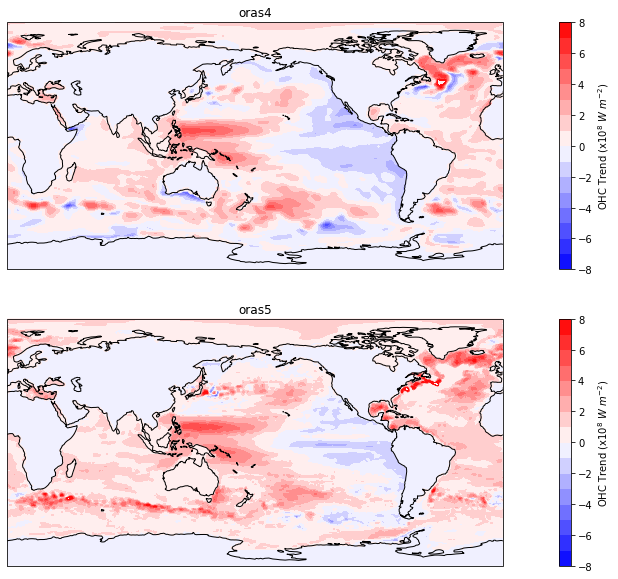

In [4]:
fig=plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1,projection=ccrs.PlateCarree(central_longitude=180.0))
m=ax1.contourf(ds1.lon,ds1.lat,hc_trend_oras4/(30*86400),levels=np.arange(-8,9,1),cmap='bwr',transform=ccrs.PlateCarree())
ax1.coastlines()
plt.colorbar(m,label='OHC Trend (x$10^{8}$ $W$ $m^{-2}$)')
plt.title('oras4')
ax1 = fig.add_subplot(2,1,2,projection=ccrs.PlateCarree(central_longitude=180.0))
m=ax1.contourf(ds1.lon,ds1.lat,hc_trend_oras5/(30*86400),levels=np.arange(-8,9,1),cmap='bwr',transform=ccrs.PlateCarree())
ax1.coastlines()
plt.colorbar(m,label='OHC Trend (x$10^{8}$ $W$ $m^{-2}$)')
plt.title('oras5')

## Indian Ocean

In [5]:
def format_axis(ax,title,label='Trend',cb_pos=[0.9, 0.78, 0.01, 0.11],opt=0):
    ax.set_xticks([30,  50,  70,  90,  110], crs=ccrs.PlateCarree())
    ax.set_yticks([ -30, -20, -10, 0, 10, 20, 30], crs=ccrs.PlateCarree())
    ax.tick_params(axis="x", labelsize=27)
    ax.tick_params(axis="y", labelsize=27)
    ax.tick_params(direction='out', length=9, width=2, colors='k',
                   grid_color='k', grid_alpha=0.7)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    plt.rcParams['hatch.linewidth'] = 0.2
    ax.coastlines(color='black', linewidth=2)
    extent = [30, 120, -30, 30]
    ax.set_extent(extent,crs=ccrs.PlateCarree())
    ax.set_title(title,  x=0.002, y=1.0, fontsize=45, weight="bold")
    ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k', facecolor='lightgrey')

    if opt:
        fig.subplots_adjust(right=0.87)
        cax = fig.add_axes(cb_pos)
        cb=fig.colorbar(plotted1, cax=cax,label=label)
        cb.ax.tick_params(labelsize=35)
        cb.set_label(label=label,size='large', weight='bold', fontsize=35)

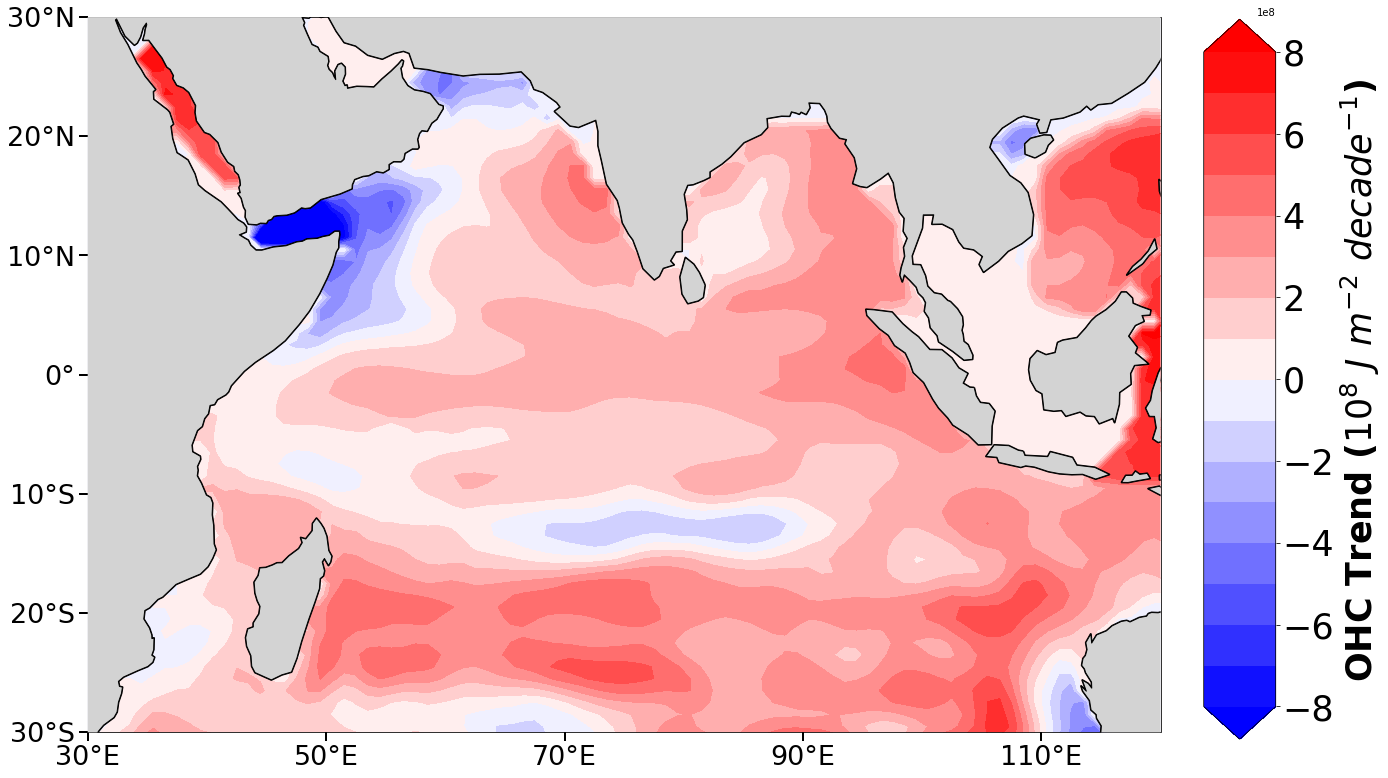

In [6]:
fig=plt.figure(figsize=(20,25))
ax1 = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree(central_longitude=180.0))
plotted1=ax1.contourf(ds1.lon,ds1.lat,hc_trend_oras4*120,levels=np.arange(-8E8,9E8,1E8),extend='both',cmap='bwr',transform=ccrs.PlateCarree())
cu_cb_pos=[0.9, 0.3, 0.05, 0.4]
format_axis(ax1,'',label='OHC Trend ($10^{8}$ $J$ $m^{-2}$ $decade^{-1}$) ',cb_pos=cu_cb_pos,opt=1)


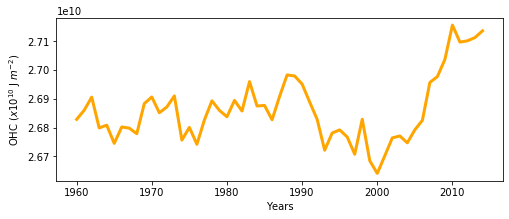

In [7]:
plt.figure(figsize=(8,3))
data=xr.open_dataset("oras4_hc_1960-2014_700m.nc")
ora=data.sel(lat=slice(-30,30),lon=slice(40,120)).mean(dim=['lat','lon'])
ora4=ora['hc'].resample(time='1Y').mean().values
plt.plot(np.arange(1960,2015,1),ora4,color='orange',linestyle='solid',alpha=1,linewidth=3,label='')
plt.ylabel('OHC ($x10^{10}$ J $m^{-2}$)',fontsize=10)
plt.xlabel('Years',fontsize=10)
plt.show()